# Machine Learning Models

In this final section, we will use Machine Learning Models to classify and predict the rank of a song on Billboard's chart with the information collected from tweets. First, we will import the necessary packages and the data we gathered and treated from the lasts sections, grouping by the change in position from week to week.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
pd.options.display.float_format = '{:.2f}'.format
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams["axes.formatter.limits"] = (-5, 12)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from scipy import stats
import shap
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import optuna
from optuna.integration import CatBoostPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [39]:
hist_agg_data = pd.read_pickle('/home/spacejao/Downloads/hist_agg_data.pkl')
agg_data_2022= pd.read_pickle('/home/spacejao/Downloads/agg_data_2022.pkl')
hist_agg_data=pd.concat([hist_agg_data,agg_data_2022],ignore_index=True)
hist_agg_data = hist_agg_data[hist_agg_data['variation'].notna()]
hist_agg_data['year']= hist_agg_data.weekdate.dt.year
hist_agg_data= hist_agg_data.reset_index(drop=True)

In [40]:
hist_agg_data.groupby('change in position').agg({'change in position':'count'})

,change in position
change in position,
down,30037
same,5898
up,25193


## Features

Now to define the data's features, we will use the: number of weeks the song stayed in the top 100 songs; the amount of retweets and favorites obtained by the tweets mentioning the song; the lastweek song position; the proportion of positive, negative and neutral tweets over the total tweets mentioning the song; and the year the tweet was made.

For the last feature, we divided the top 100 songs in 5 categories, from top 20 to bottom 20. We found out that songs on the top of the ranking didn't move as much as songs at the bottom. Including this feature helped to calibrate the estimations.

In [41]:
hist_agg_data=hist_agg_data.fillna(0)
hist_agg_data['top_20']=np.where(hist_agg_data['position']<= 20, 1 ,0)
hist_agg_data['20_40']=np.where((hist_agg_data['position']<= 40) & (hist_agg_data['position']> 20) , 1 ,0)
hist_agg_data['40_60'] =np.where((hist_agg_data['position']<= 60) & (hist_agg_data['position']> 40) , 1 ,0)
hist_agg_data['60_80']=np.where((hist_agg_data['position']<= 80) & (hist_agg_data['position']> 60) , 1 ,0)
hist_agg_data['80_100']=np.where((hist_agg_data['position']<= 100) & (hist_agg_data['position']> 80), 1 ,0)

In [42]:
hist_agg_data['prop_positive']= hist_agg_data['positive']/hist_agg_data['sentment']
hist_agg_data['prop_negative']= hist_agg_data['negative']/hist_agg_data['sentment']
hist_agg_data['prop_neutral']= hist_agg_data['neutral']/hist_agg_data['sentment']

In [43]:
features_top= [ 'weeks', 'retweets',
       'favorites', 'lastweek','prop_positive','prop_negative','prop_neutral', 'year','top_20', '20_40','40_60','60_80']
hist_agg_data=hist_agg_data.fillna(0)

In [44]:
def encode_change(change):
    if change in ('down', 'same'):
        return 0
    elif change=='up':
        return 1
hist_agg_data['change']= hist_agg_data.loc[:,'change in position'].apply(lambda x: encode_change(x) )


## Random Forest with XGBoost

With the data and features in hands, we are ready to train our model. We will be using a random forest algorithm with the XGBoost package. XGBoost uses CART trees (Classify And Regression Trees) as base learner Decision Tree. We will classify the movements in either "up" movements and "no up" movements, with the last one including both musics that went down in rank or remained still.

In [45]:
xtr, xval, ytr, yval = train_test_split(hist_agg_data[features_top], hist_agg_data['change'], test_size=0.2, random_state=1)

In [46]:
class__initial= xgb.XGBClassifier(n_estimators =500, eta=0.01)

In [47]:
class__initial.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
        verbose=True,)
results = class__initial.evals_result()

[0]	validation_0-logloss:0.69079	validation_1-logloss:0.69083
[1]	validation_0-logloss:0.68845	validation_1-logloss:0.68854
[2]	validation_0-logloss:0.68618	validation_1-logloss:0.68631
[3]	validation_0-logloss:0.68362	validation_1-logloss:0.68377
[4]	validation_0-logloss:0.68121	validation_1-logloss:0.68136
[5]	validation_0-logloss:0.67873	validation_1-logloss:0.67890
[6]	validation_0-logloss:0.67663	validation_1-logloss:0.67684
[7]	validation_0-logloss:0.67456	validation_1-logloss:0.67481
[8]	validation_0-logloss:0.67230	validation_1-logloss:0.67254
[9]	validation_0-logloss:0.67031	validation_1-logloss:0.67058
[10]	validation_0-logloss:0.66838	validation_1-logloss:0.66869
[11]	validation_0-logloss:0.66616	validation_1-logloss:0.66648
[12]	validation_0-logloss:0.66428	validation_1-logloss:0.66464
[13]	validation_0-logloss:0.66213	validation_1-logloss:0.66251
[14]	validation_0-logloss:0.66012	validation_1-logloss:0.66056
[15]	validation_0-logloss:0.65828	validation_1-logloss:0.65876
[1

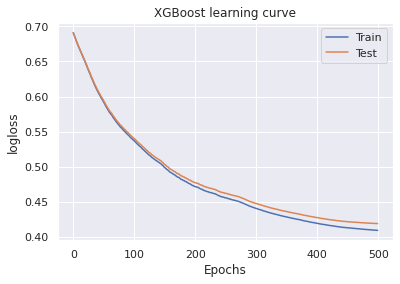

In [49]:
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.title('XGBoost learning curve')
plt.show()

From the learning curve graph we can see the model has overall a good fit, with both train and validation loss in a point of stability and with the small gap between the two. Let's visualize the proportion of right guesses in the label classification

Confusion matrix, without normalization
[[6288  956]
 [1622 3360]]
Normalized confusion matrix
[[0.86802871 0.13197129]
 [0.32557206 0.67442794]]


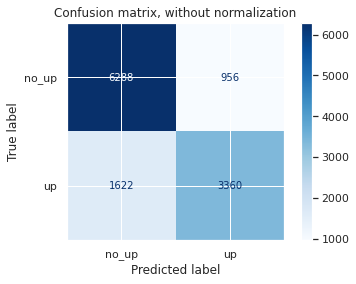

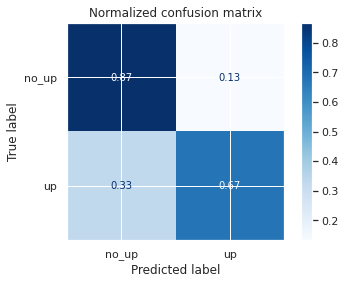

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
class_labels =['no_up', 'up']
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        class__initial,
        xval,
        yval,
        display_labels=class_labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

As we can see, the model seems to have an easier time classyfing ups movements than no up movements. The most likely reason for this result is the proportion of songs that did not change position from week to week in the time period sampled: only 9.64%! Therefore, it's easier for the model to ignore the songs that remained still and predict only ups and downs, since these occur way more frequently.

If we want a model with better accuracy in predicting that a music will not change position in the ranks, we can downsample the number of "up" and "down" labels to be equal to "same" label. We will do this in the next section

## Model with Downsampling

The only difference of this model to the last one is the downsampling of the labels.

In [51]:
rus = RandomUnderSampler(random_state=3)

x_rus, y_rus = rus.fit_resample(hist_agg_data[features_top], hist_agg_data['change'])

In [52]:
y_rus.value_counts()

0    25193
1    25193
Name: change, dtype: int64

In [53]:
x_rus['change'] = y_rus

In [54]:
xtr, xval, ytr, yval = train_test_split(x_rus[features_top], x_rus['change'], test_size=0.1, random_state=1)

In [55]:
xtr, xtest, ytr, ytest = train_test_split(xtr, ytr, test_size=0.1, random_state=1)

In [56]:
class__downed= xgb.XGBClassifier(n_estimators =500, eta=0.01)

In [57]:
class__downed.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
        verbose=True,)
results = class__downed.evals_result()

[0]	validation_0-logloss:0.69111	validation_1-logloss:0.69127
[1]	validation_0-logloss:0.68919	validation_1-logloss:0.68952
[2]	validation_0-logloss:0.68720	validation_1-logloss:0.68771
[3]	validation_0-logloss:0.68526	validation_1-logloss:0.68592
[4]	validation_0-logloss:0.68345	validation_1-logloss:0.68427
[5]	validation_0-logloss:0.68168	validation_1-logloss:0.68266
[6]	validation_0-logloss:0.67981	validation_1-logloss:0.68096
[7]	validation_0-logloss:0.67801	validation_1-logloss:0.67930
[8]	validation_0-logloss:0.67633	validation_1-logloss:0.67778
[9]	validation_0-logloss:0.67457	validation_1-logloss:0.67616
[10]	validation_0-logloss:0.67297	validation_1-logloss:0.67471
[11]	validation_0-logloss:0.67006	validation_1-logloss:0.67195
[12]	validation_0-logloss:0.66733	validation_1-logloss:0.66937
[13]	validation_0-logloss:0.66454	validation_1-logloss:0.66677
[14]	validation_0-logloss:0.66182	validation_1-logloss:0.66418
[15]	validation_0-logloss:0.65924	validation_1-logloss:0.66174
[1

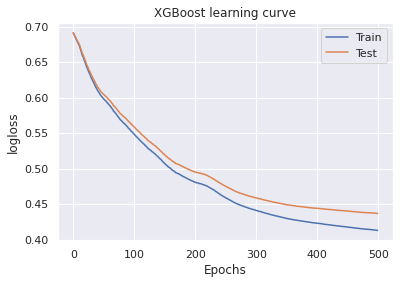

In [59]:
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.title('XGBoost learning curve')
plt.show()

Confusion matrix, without normalization
[[1765  497]
 [ 535 1738]]
Normalized confusion matrix
[[0.78028294 0.21971706]
 [0.23537176 0.76462824]]


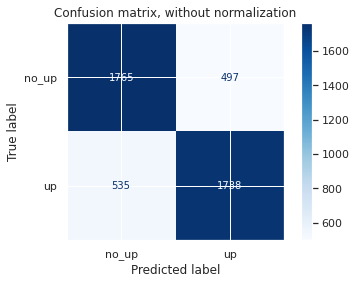

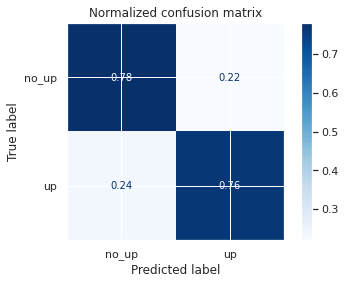

In [78]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        class__downed,
        xtest,
        ytest,
        display_labels=class_labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The learning curves again have overall a good fit and as the matrix shows, the model can now predict both "up" and "no up" movements if almost the same accuracy.

#### Hyperparameter tunning

For hyperparameter tunning we will use the Optuna package, a hyperparameter optimization software framework. Optuna tunnes the hyperparameters by sampling from a defined space of hyperparameters the best combination which minimizes our loss function, using a Bayesian optimization algorithm .

In [61]:
def objective(trial):
    #callback = [CatBoostPruningCallback(trial, 'logloss')]

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(xtr, ytr)
    y_pred = optuna_model.predict(xval)
    loss = 1 - recall_score(yval, y_pred, average='micro')



    
    return loss if loss != np.nan else float("inf")

In [62]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, timeout=7200, n_trials=200)

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])
    
# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


[I 2023-02-08 23:17:11,731] A new study created in memory with name: no-name-d6f0bf97-8925-4b9d-b753-f6a23244abe7
[I 2023-02-08 23:17:12,819] Trial 0 finished with value: 0.3056161936892241 and parameters: {'max_depth': 2, 'learning_rate': 0.4788572624486633, 'n_estimators': 351, 'min_child_weight': 10, 'gamma': 0.00033925803139577974, 'subsample': 0.01696069127749321, 'colsample_bytree': 0.043024311040940164, 'reg_alpha': 2.2506058225865644e-07, 'reg_lambda': 0.2613376192249961}. Best is trial 0 with value: 0.3056161936892241.
[I 2023-02-08 23:17:13,818] Trial 1 finished with value: 0.34490970430641 and parameters: {'max_depth': 2, 'learning_rate': 0.05570933707448716, 'n_estimators': 418, 'min_child_weight': 6, 'gamma': 2.840148943970921e-07, 'subsample': 0.016399425360798543, 'colsample_bytree': 0.08259697138364085, 'reg_alpha': 0.07194414352115627, 'reg_lambda': 0.0005726932128117469}. Best is trial 0 with value: 0.3056161936892241.
[I 2023-02-08 23:17:15,661] Trial 2 finished with

Best value: 0.219884897797182, Best params: {'max_depth': 9, 'learning_rate': 0.024799462399386015, 'n_estimators': 345, 'min_child_weight': 10, 'gamma': 0.008369274842618724, 'subsample': 0.1995259232321706, 'colsample_bytree': 0.7283520437609754, 'reg_alpha': 1.9622581213364766e-05, 'reg_lambda': 5.82331660720621e-08}


In [63]:
class_best= xgb.XGBClassifier(**study.best_trial.params)

In [64]:
class_best.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        verbose=True)
results = class_best.evals_result()

[0]	validation_0-logloss:0.68676	validation_1-logloss:0.68700
[1]	validation_0-logloss:0.68336	validation_1-logloss:0.68400
[2]	validation_0-logloss:0.67731	validation_1-logloss:0.67839
[3]	validation_0-logloss:0.67275	validation_1-logloss:0.67439
[4]	validation_0-logloss:0.66546	validation_1-logloss:0.66756
[5]	validation_0-logloss:0.66256	validation_1-logloss:0.66500
[6]	validation_0-logloss:0.65640	validation_1-logloss:0.65912
[7]	validation_0-logloss:0.65081	validation_1-logloss:0.65392
[8]	validation_0-logloss:0.64831	validation_1-logloss:0.65203
[9]	validation_0-logloss:0.64623	validation_1-logloss:0.65038
[10]	validation_0-logloss:0.64396	validation_1-logloss:0.64828
[11]	validation_0-logloss:0.63820	validation_1-logloss:0.64295
[12]	validation_0-logloss:0.63620	validation_1-logloss:0.64145
[13]	validation_0-logloss:0.63435	validation_1-logloss:0.64001
[14]	validation_0-logloss:0.63249	validation_1-logloss:0.63843
[15]	validation_0-logloss:0.63052	validation_1-logloss:0.63670
[1

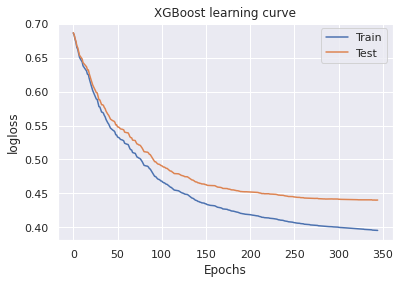

In [65]:
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.title('XGBoost learning curve')
plt.show()

Confusion matrix, without normalization
[[1775  487]
 [ 526 1747]]
Normalized confusion matrix
[[0.7847038  0.2152962 ]
 [0.23141223 0.76858777]]


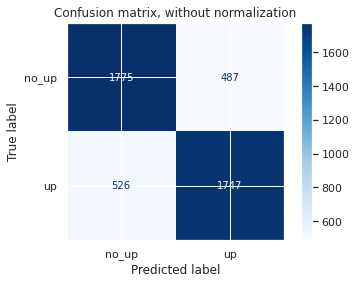

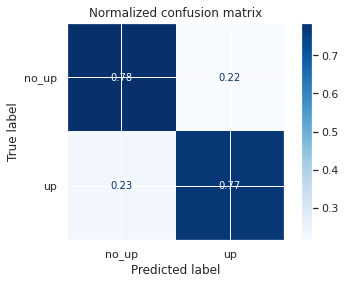

In [77]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        class_best,
        xtest,
        ytest,
        display_labels=class_labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

The version of the model with the hyperparameter tunning makes a little improvement in the model perfomance. Taking a look in the precision metric of the three models, we can see that the last models which includes the downsampling and the hyperparameter tunning has the best perfomance:

In [67]:
predict_1=class__downed.predict(xtest)
recall_score(predict_1,ytest, average='macro')

0.7725099698472911

In [68]:
predict_2=class_best.predict(xtest)
recall_score(predict_2,ytest, average='macro')

0.7767045545181595

In [69]:
predict_3 = class__initial.predict(xtest)
recall_score(predict_3,ytest, average='macro')

0.7850675029990037

#### cross-validation

Finally, we use cross-validation for model validation. The results show that the model hast a good fit, reinforcing our analysis of the learning curves graph previously made.

In [70]:
cv_df = x_rus.sample(len(x_rus))

In [71]:
from sklearn.model_selection import cross_val_score

In [72]:
scores_best = cross_val_score(class_best, cv_df[features_top], cv_df['change'], cv=5,scoring='recall_macro')

In [73]:
scores_initial= cross_val_score(class__initial, cv_df[features_top], cv_df['change'], cv=5, scoring='recall_macro')

In [74]:
scores_downed = cross_val_score(class__downed, cv_df[features_top], cv_df['change'], cv=5, scoring='recall_macro')

In [75]:
print(f'class_initial: {scores_initial.mean()}',f'class_downed: {scores_downed.mean()}', f'class_best: {scores_best.mean()}')

class_initial: 0.7831343862454041 class_downed: 0.7831343862454041 class_best: 0.7826778164851672
